In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog
from scipy.stats import linregress
from pulp import *

sns.set(style="white")
%matplotlib inline

In [2]:
data = (pd.read_csv("data/clean-data.csv")
        .sort_values(by=['Points', 'Cost'])
        .reset_index(drop=True))

# Dynamic Programming

In [3]:
def knapSack(W, wt, val, n):
    K = [[0 for x in range(W+1)] for x in range(n+1)] 
    for i in range(n+1):
        for w in range(W+1):
            if i==0 or w==0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    return K

def knapSackIndex(W, wt, val, n, K):
    res = K[-1][-1]
    ix = []
    w = W
    ix = []
    for i in range(n, 0, -1):
        if res <= 0:
            break
        if res == K[i - 1][w]:
            continue
        else:
            ix.append(i-1)
            res = res - val[i - 1]
            w = w -  wt[i - 1]
    return ix

In [4]:
# Example
val = [60, 100, 120, 120]
wt = [10, 20, 30, 20]
W = 50
n = len(val)
K = knapSack(W, wt, val, n)
ix = knapSackIndex(W, wt, val, n ,K)

In [5]:
print("Max value:{}, with items:{}".format(K[-1][-1], str(ix)))

Max value:280, with items:[3, 1, 0]


In [6]:
points = data['Points'].tolist()
cost   = (data['Cost'] * 10).astype(int).tolist()
C      = 100 * 10
n      = len(points)
K = knapSack(C, cost, points, n)
ix = knapSackIndex(C, cost, points, n, K)

In [7]:
ix_array = np.array(ix)
ix_points = data["Points"][ix_array]
total_points = (ix_points.sum() + ix_points.max())
total_cost = data["Cost"][ix_array].sum()
print("Total points:{}, cost:£{}, and with players:{}".format(total_points, total_cost, len(ix)))

Total points:2842.0, cost:£99.9, and with players:11


In [8]:
data[['Player','Position','Points','Cost']].iloc[ix_array,:]

,Player,Position,Points,Cost
522,"SALAH, M",STR,378.0,12.9
521,"DE BRUYNE, K",MID,281.0,12.0
519,"OTAMENDI, N",DEF,244.0,10.2
518,"AZPILICUETA, C",DEF,240.0,10.3
517,"ERIKSEN, C",MID,230.0,11.2
514,"DE GEA, D",GK,218.0,8.0
507,"MORAES, E",GK,188.0,7.9
502,"LLORIS, H",GK,183.0,7.5
497,"POPE, N",GK,175.0,6.9
493,"RYAN, M",GK,172.0,6.5


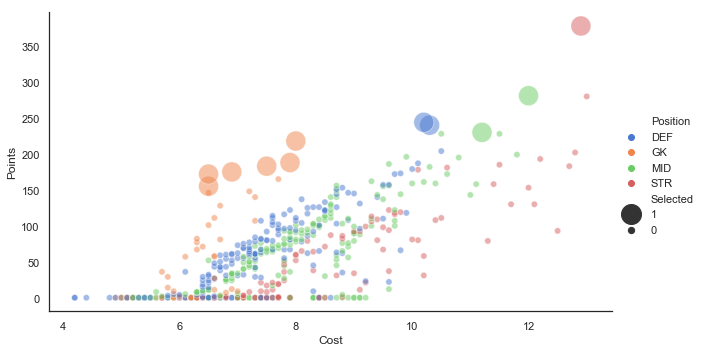

In [9]:
data['Selected'] = 0
data.loc[ix_array, 'Selected'] = 1
sns.relplot(x="Cost", y="Points", 
            hue="Position", size='Selected',
            size_order=[1,0],
            sizes=(40, 400), alpha=.5, 
            palette="muted", height=5, aspect=1.75,
            data=data)

# Linear Programming

In [10]:
from scipy.optimize import linprog

In [11]:
points = data['Points']
cost = data['Cost']
gk   = data['Position'].apply(lambda x: 1 if x == 'GK' else 0)
defe = data['Position'].apply(lambda x: 1 if x == 'DEF' else 0)
mid  = data['Position'].apply(lambda x: 1 if x == 'MID' else 0)
stri = data['Position'].apply(lambda x: 1 if x == 'STR' else 0)
xi   = np.ones(data.shape[0])

A_upperbounds = np.array([
    cost, defe, mid, stri
])

b_upperbounds = np.array([
    100, 5, 5, 3
])

A_equality = np.array([
    gk, xi
])

b_equality = np.array([
    1, 11
])

bounds = [(0, 1) for x in range(data.shape[0])]

In [12]:
solution = linprog(
    c=-points,
    A_ub=A_upperbounds,
    b_ub=b_upperbounds,
    A_eq=A_equality,
    b_eq=b_equality,
    bounds=bounds
)

In [13]:
solution.x[solution.x > 0]

array([0.50877193, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.49122807, 1.        , 1.        , 1.        ,
       1.        , 1.        ])

# Integer Programming

In [14]:
from pulp import *

In [15]:
player = [str(i) for i in range(data.shape[0])]
point = {str(i): data['Points'][i] for i in range(data.shape[0])} 
cost = {str(i): data['Cost'][i] for i in range(data.shape[0])}
gk = {str(i): 1 if data['Position'][i] == 'GK' else 0 for i in range(data.shape[0])}
defe = {str(i): 1 if data['Position'][i] == 'DEF' else 0 for i in range(data.shape[0])}
mid = {str(i): 1 if data['Position'][i] == 'MID' else 0 for i in range(data.shape[0])}
stri = {str(i): 1 if data['Position'][i] == 'STR' else 0 for i in range(data.shape[0])}
xi = {str(i): 1 for i in range(data.shape[0])}

In [16]:
prob = LpProblem("Fantasy Football",LpMaximize)
player_vars = LpVariable.dicts("Players",player,0,1,LpBinary)

In [17]:
# objective function
prob += lpSum([point[i]*player_vars[i] for i in player]), "Total Cost"

In [18]:
# constraint
prob += lpSum([player_vars[i] for i in player]) == 11, "Total 11 Players"
prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 100.0, "Total Cost"
prob += lpSum([gk[i] * player_vars[i] for i in player]) == 1, "Only 1 GK"
prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 4, "Less than 4 DEF"
prob += lpSum([mid[i] * player_vars[i] for i in player]) <= 5, "Less than 5 MID"
prob += lpSum([stri[i] * player_vars[i] for i in player]) <= 3, "Less than 3 STR"

In [19]:
# solve
status = prob.solve()

In [20]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

Status: Optimal


In [21]:
selection = {}
for v in prob.variables():
    index = int(v.name.split("_")[1])
    selection[index] = v.varValue
#     print(v.name, "=", v.varValue)

In [22]:
data['integer_programming'] = 0.0
for i in selection:
    data.loc[i, 'integer_programming'] = selection[i]

In [23]:
XI = data[data['integer_programming'] == 1.0]
TOTAL_POINTS = XI['Points'].sum()
TOTAL_COST = XI['Cost'].sum()
TOTAL_PLAYERS = XI.shape[0]
print("Total points:{}, cost:£{}, and with players:{}".format(TOTAL_POINTS, TOTAL_COST, TOTAL_PLAYERS))

Total points:2095.0, cost:£100.00000000000001, and with players:11


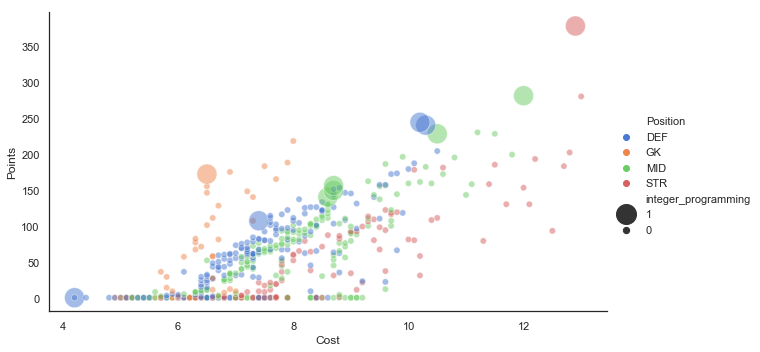

In [24]:
sns.relplot(x="Cost", y="Points", 
            hue="Position", size='integer_programming',
            size_order=[1,0],
            sizes=(40, 400), alpha=.5, 
            palette="muted", height=5, aspect=1.75,
            data=data)

In [25]:
(XI[['Player','Position','Points','Cost']]
 .sort_values(['Position'])
 .reset_index(drop=True))

,Player,Position,Points,Cost
0,"EBANKS-LANDELL, E",DEF,0.0,4.2
1,"WARD, S",DEF,107.0,7.4
2,"AZPILICUETA, C",DEF,240.0,10.3
3,"OTAMENDI, N",DEF,244.0,10.2
4,"RYAN, M",GK,172.0,6.5
5,RICHARLISON,MID,140.0,8.6
6,"MOOY, A",MID,149.0,8.7
7,"DOUCOURE, A",MID,156.0,8.7
8,"SILVA, D",MID,228.0,10.5
9,"DE BRUYNE, K",MID,281.0,12.0


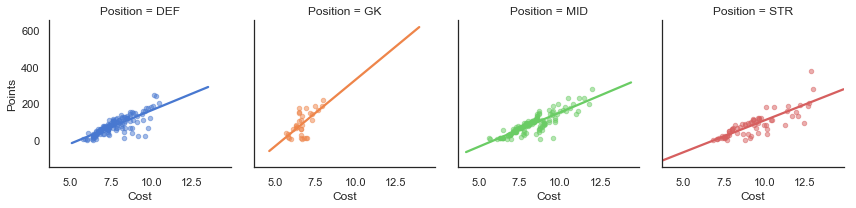

In [26]:
sns.lmplot(x="Cost", y="Points", col="Position", hue="Position", 
           data=data[data.Points != 0],
           col_wrap=4, ci=None, palette="muted", height=3,
           hue_order=['DEF','GK','MID', 'STR'],
           col_order=['DEF','GK','MID', 'STR'],
           scatter_kws={"s": 20, "alpha": 0.5})

In [27]:
slope_inter = {}
for pos in ['DEF','GK','MID', 'STR']:
    pos_data = data[(data.Position == pos) & (data.Points > 0)].reset_index(drop=True)
    output = linregress(pos_data['Cost'],pos_data['Points'])
    print("For {}, y = {:0.3f}x + {:0.3f}".format(pos, output.slope, output.intercept))
    slope_inter[pos] = {"slope":output.slope, "intercept":output.intercept}

For DEF, y = 36.483x + -203.343
For GK, y = 73.302x + -402.909
For MID, y = 37.443x + -224.493
For STR, y = 34.876x + -242.834


# Imputation for New EPL Players
 - No change in selection

In [28]:
def get_adj_points(x, slope_intercept):
    if x.Points > 0:
        return x.Points
    else:
        mb = slope_intercept[x.Position]
        adj_points = mb['slope'] * x.Cost + mb['intercept']
        if adj_points > 0:
            return int(adj_points)
        else:
            return 0

In [29]:
data['AdjPoints'] = data[['Position','Points','Cost']].apply(lambda x: get_adj_points(x, slope_inter), axis=1)

In [30]:
adjpoint = {str(i): data['AdjPoints'][i] for i in range(data.shape[0])} 

In [31]:
prob = LpProblem("Fantasy Football",LpMaximize)
player_vars = LpVariable.dicts("Players",player,0,1,LpBinary)

# objective function
prob += lpSum([adjpoint[i]*player_vars[i] for i in player]), "Total Cost"

# constraint
prob += lpSum([player_vars[i] for i in player]) == 11, "Total 11 Players"
prob += lpSum([cost[i] * player_vars[i] for i in player]) <= 100.0, "Total Cost"
prob += lpSum([gk[i] * player_vars[i] for i in player]) == 1, "Only 1 GK"
prob += lpSum([defe[i] * player_vars[i] for i in player]) <= 4, "Less than 5 DEF"
prob += lpSum([mid[i] * player_vars[i] for i in player]) <= 5, "Less than 5 MID"
prob += lpSum([stri[i] * player_vars[i] for i in player]) <= 3, "Less than 3 STR"

# solve
status = prob.solve()

# selection
selection = {}
for v in prob.variables():
    index = int(v.name.split("_")[1])
    selection[index] = v.varValue
    
data['Adj Selection'] = 0.0
for i in selection:
    data.loc[i, 'Adj Selection'] = selection[i]
    
XI = data[data['Adj Selection'] == 1.0]
TOTAL_POINTS = XI['AdjPoints'].sum()
TOTAL_COST = XI['Cost'].sum()
TOTAL_PLAYERS = XI.shape[0]
print("Total points:{}, cost:£{}, and with players:{}".format(TOTAL_POINTS, TOTAL_COST, TOTAL_PLAYERS))

Total points:2095.0, cost:£100.00000000000001, and with players:11


In [32]:
(XI[['Player','Position','Points','AdjPoints','Cost']]
 .sort_values(['Position'])
 .reset_index(drop=True))

,Player,Position,Points,AdjPoints,Cost
0,"EBANKS-LANDELL, E",DEF,0.0,0.0,4.2
1,"WARD, S",DEF,107.0,107.0,7.4
2,"AZPILICUETA, C",DEF,240.0,240.0,10.3
3,"OTAMENDI, N",DEF,244.0,244.0,10.2
4,"RYAN, M",GK,172.0,172.0,6.5
5,RICHARLISON,MID,140.0,140.0,8.6
6,"MOOY, A",MID,149.0,149.0,8.7
7,"DOUCOURE, A",MID,156.0,156.0,8.7
8,"SILVA, D",MID,228.0,228.0,10.5
9,"DE BRUYNE, K",MID,281.0,281.0,12.0
